In [81]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

Now we define our domain to be defined from `begin=-10` to `end=10`

In [82]:
begin = -10.0
end = 10.0
n = 1000
x = np.linspace(begin, end, n)

The time interval we will consider is $t_f-t_i=1$ with a time step $dt$ equal to $(t_f-t_i)/nts$

In [83]:
ti = 0
tf = 1
ts = 1000
dt = (tf-ti)/ts

We are considering a fake particle of mass $M=2000$

In [84]:
M_0=2000

Then we define our initial wavefunction $$\psi_{0} = e^{\frac{(x-x_0)^2}{\sigma^2}}e^{ik\cdot x} $$ where the wavepacket is coming from the left end with a positive momentum towards the right end

In [85]:
x_0 = -8.5
k_0 = 5.0
sigma = 0.5
psi_0 = np.exp(-(x-x_0)*(x-x_0)/sigma**2)/np.sqrt(2*np.pi*sigma**2)

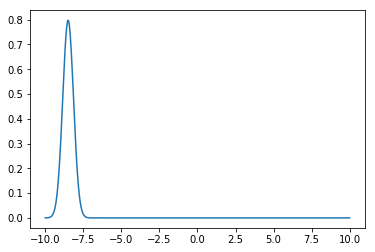

In [86]:
plt.figure()
plt.plot(x,psi_0)
plt.show()

In [87]:
psi_0 = psi_0*np.exp(1j*x*k_0)

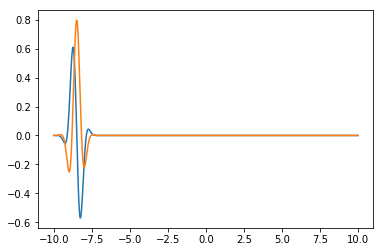

In [88]:
plt.figure()
plt.plot(x,np.real(psi_0))
plt.plot(x,np.imag(psi_0))
plt.show()

In [89]:
def Potential(x):
    A = 0.01
    B = 1.6
    C = 0.005
    D = 1.0
    V = np.zeros((2,2))
    if x>0:
        V[0,0] = A*(1-np.exp(-B*x))
    else:
        V[0,0] = -A*(1-np.exp(B*x))
    V[1,1] = -V[0,0]
    V[0,1] = C*np.exp(-D*x**2)
    V[1,0] = V[0,1]
    return V

In [90]:
e_vals = np.zeros((2,n))
e_vecs = np.zeros((4,n))
for i in range(n):
    vals, vecs = LA.eigh(Potential(x[i]))
    e_vals[:,i] = vals
    e_vecs[0:2,i] = vecs[:,0]
    e_vecs[2:4,i] = vecs[:,1]

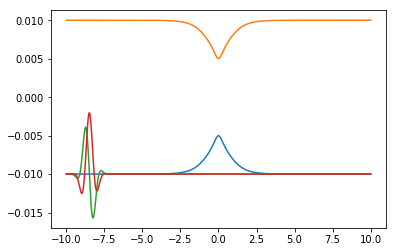

In [91]:
plt.figure()
plt.plot(x,e_vals[0,:]) # lower surface
plt.plot(x,e_vals[1,:]) # upper surface
plt.plot(x,np.real(psi_0)/100+e_vals[0,0])
plt.plot(x,np.imag(psi_0)/100+e_vals[0,0])
plt.show()


Now we have to apply the evolution (unitary) operator to the initial state. For doing so we apply the Trotter decomposition formula. We split the evolution operator in the following way:
$$\mathcal{U}=e^{i\hat{H}t}=e^{i\hat{T}t/2}e^{i\hat{V}t}e^{i\hat{T}t/2} $$
The potential energy operator is diagonal (in the _diabatic_ representation), then is easy to handle since is only a multiplication in real space. The kinetic energy operator must be handled in the reciprocal space, thanks to the `fft` command. 

## Kinetic Step
Applying the operator 
$$ e^{i\hat{T}t/2} $$
to the wavefunction $\psi$ is equivalent to multiply its Fourier transform $\mathcal{F}[\psi(x)](k)$ by its kinetic energy. The most powerful feature of the `fft` is that requires only a $O(n\log n)$ computational cost.

In [101]:
# the problem in the following multiplication is that I have to divide real part and imaginary part of the kinetic energy
psi = np.zeros((2,n),dtype=complex)
psi[0,:] = psi_0
# now we have to instantiate the (complex valued) Fourier transform of 
psi_k = np.zeros((2,n),dtype=complex)
# every calculation has to be performed on the first state and on the second state
psi_k[0,:] = np.fft.fft(psi[0,:])
psi_k[1,:] = np.fft.fft(psi[1,:])
# multiplication in the fourier space
psi_k[0,:] = -(np.cos(dt/2*k_0*k_0/2/M_0) + 1j*np.sin(dt/2*k_0*k_0/2/M_0))*psi_k[0,:]
psi_k[1,:] = -(np.cos(dt/2*k_0*k_0/2/M_0) + 1j*np.sin(dt/2*k_0*k_0/2/M_0))*psi_k[1,:]
# inverse fourier transform
psi[0,:] = np.fft.ifft(psi_k[0,:])
psi[1,:] = np.fft.ifft(psi_k[1,:])

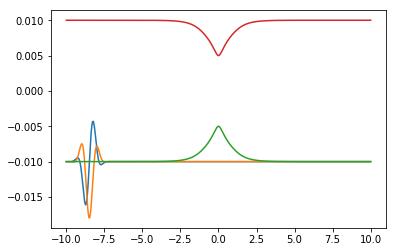

In [98]:
plt.figure()
plt.plot(x,np.real(psi[0,:])/100+e_vals[0,0])
plt.plot(x,np.imag(psi[0,:])/100+e_vals[0,0])
plt.plot(x,e[0,:])
plt.plot(x,e[1,:])
plt.show()

## Potential step
We perform the potential step by first going from the **diabatic to the adiabatic** representation, then we perform the evolution in the new representation (that is nothing more a 1 dimensional problem) and in the end we come back to the original representation, preforming the **adiabatic to diabatic** transformation. 

### diabatic to adiabatic
We have to perform the transformation $\psi'=\mathcal{U}^{\dagger}\psi$ where $\mathcal{U}$ is the matrix that diagonalizes $V$

In [114]:
psi_adi = np.zeros((2,n),dtype=complex)
for i in range(n):
    # for unitary matrix the transform is equal to the inverse, so we only have to write the transpose
    U_t = [[e_vecs[0,i], e_vecs[1,i]],[e_vecs[2,i], e_vecs[3,i]]] 
    psi_adi[:,i] = np.dot(U_t,[psi[0,i],psi[1,i]])
psi_adi[0,:] = psi_adi[0,:]*(np.cos(e_vals[0,:]*dt)-1j*np.sin(e_vals[0,:]*dt))
psi_adi[1,:] = psi_adi[1,:]*(np.cos(e_vals[1,:]*dt)-1j*np.sin(e_vals[1,:]*dt))
for i in range(n):
    U = [[e_vecs[0,i], e_vecs[2,i]],[e_vecs[1,i], e_vecs[3,i]]] 
    psi[:,i] = np.dot(U,[psi_adi[0,i],psi_adi[1,i]])    

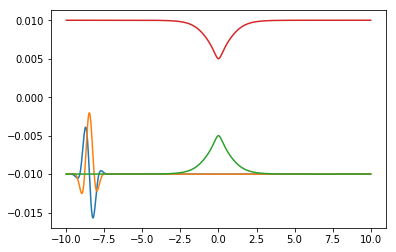

In [115]:
plt.figure()
plt.plot(x,np.real(psi[0,:])/100+e_vals[0,0])
plt.plot(x,np.imag(psi[0,:])/100+e_vals[0,0])
plt.plot(x,e[0,:])
plt.plot(x,e[1,:])
plt.show()

In [116]:
# second half step in the kinetic energy
psi_k = np.fft.fft(psi)
psi_k = -(np.cos(dt/2*k_0*k_0/2/M_0) + 1j*np.sin(dt/2*k_0*k_0/2/M_0))*psi_k
psi = np.fft.ifft(psi_k)

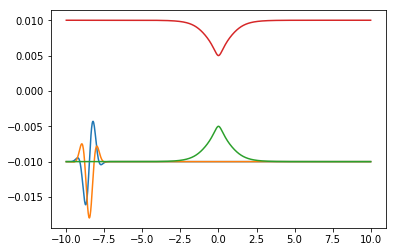

In [117]:
plt.figure()
plt.plot(x,np.real(psi[0,:])/100+e_vals[0,0])
plt.plot(x,np.imag(psi[0,:])/100+e_vals[0,0])
plt.plot(x,e[0,:])
plt.plot(x,e[1,:])
plt.show()